<a href="https://colab.research.google.com/github/Fourzeroo/My-Certificates/blob/main/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1: Настройка среды выполнения графического процессора colab

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

# Загрузка данных

Автор данных :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 21.20 MiB/s, done.
Resolving deltas: 100% (3/3), done.


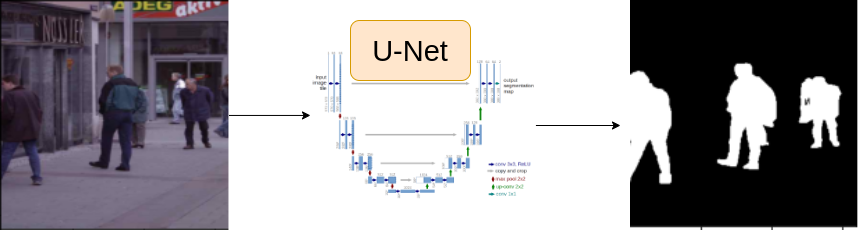

# Загрузка модулей

In [4]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [5]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [71]:
csv_file = '/content/Human-Segmentation-Dataset-master/train.csv'
data_dir = '/content/'

device = 'cuda'
epochs = 30
lr = 0.005
image_size = 320
batch_size = 15

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [33]:
df = pd.read_csv(csv_file)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [34]:
row = df.iloc[41]

image_path = row.images # Изображение
mask_path = row.masks   # Маска(таргет)

image = cv2.imread(image_path)
image = cv2.cvtColor(image, 1)

masks = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0


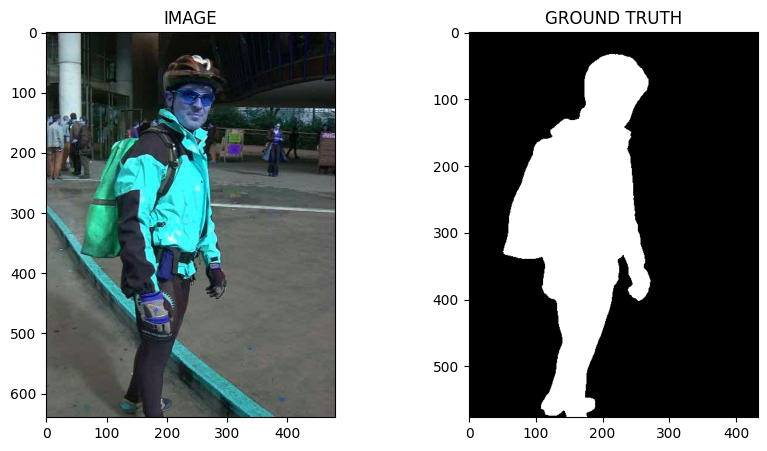

In [35]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(masks, cmap='gray');

In [36]:
df_train, df_valid = train_test_split(df, test_size=0.2, random_state=10)

# 3: Функции расширения

In [37]:
import albumentations as A

In [46]:
def get_train_augs():
  return A.Compose(
      [
          A.Resize(image_size, image_size),
          A.HorizontalFlip(p=0.5),
          A.VerticalFlip(p=0.5),
          A.RandomBrightnessContrast(p=0.3)
      ]
  )


def get_valid_augs():
  return A.Compose(
      [
          A.Resize(image_size, image_size)
      ]
  )

# 4 : Соберем наш датасет

In [39]:
from torch.utils.data import Dataset

In [84]:
class SegmentationDataset(Dataset):

    def __init__(self, df, augmentations):

        self.df = df
        self.augmentations = augmentations
        self.transform = A.Compose(augmentations, is_check_shapes=False)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.iloc[index]
        image_path = row.images
        mask_path = row.masks

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, 1)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h, w, c)
        mask = np.expand_dims(mask, axis=-1)

        if self.augmentations:
            data = self.transform(image=image, mask=mask)  # Применяем аугментации
            image = data['image']
            mask = data['mask']

        #(h, w, c) -> (c, h, w)
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)
        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) /255.0)
        return image, mask

In [85]:
trainset = SegmentationDataset(df_train, get_train_augs())
validset = SegmentationDataset(df_valid, get_valid_augs())

/usr/local/lib/python3.10/dist-packages/albumentations/core/composition.py:53: UserWarning: transforms is single transform, but a sequence is expected! Transform will be wrapped into list.
  warnings.warn(


In [86]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


# 5 : Создавние DataLoader'а

In [87]:
from torch.utils.data import DataLoader


In [88]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_size, shuffle=False)

In [89]:
print(len(trainloader), len(validloader))

16 4


# 6 : Построение модели

In [90]:
from torch import nn, optim
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [91]:
class SegmentationModel(nn.Module):

    def __init__(self) -> None:
        super(SegmentationModel, self).__init__()

        self.arc = smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None
        )

    def forward(self, images, masks=None):

        logits = self.arc(images)

        if masks != None:
            loss1 = DiceLoss(mode='binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2

        return logits


In [92]:
model = SegmentationModel()
model.to(device=0)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# 7 : Создание функций для тренировки и оценки модели

In [93]:
def train_model(data_loader, model, optimizer):

    model.train()
    total_loss = 0.0

    for images, masks in tqdm(data_loader):
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return(total_loss / len(data_loader))

In [94]:
def eval_model(data_loader, model):

    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(device)
            masks = masks.to(device)

            logits, loss = model(images, masks)

            total_loss += loss.item()

    return(total_loss / len(data_loader))

# 8 : Тренировка модели

In [95]:
optimizer = optim.Adam(model.parameters(), lr=lr)

In [97]:
best_valid_loss = np.Inf

for i in range(10):

    train_loss = train_model(trainloader, model, optimizer)
    valid_loss = eval_model(validloader, model)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), 'best_model.pytorch')
        print('SAVED_MODEL')
        best_valid_loss = valid_loss

    print(f'epoch{i + 1} Train loss: {train_loss} Valid loss: {valid_loss}')

100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


SAVED_MODEL
epoch1 Train loss: 0.13296827115118504 Valid loss: 0.23279725387692451


100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


SAVED_MODEL
epoch2 Train loss: 0.13572785258293152 Valid loss: 0.19138363748788834


100%|██████████| 4/4 [00:00<00:00,  4.44it/s]


SAVED_MODEL
epoch3 Train loss: 0.12931830761954188 Valid loss: 0.17808131128549576


100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


epoch4 Train loss: 0.11379447812214494 Valid loss: 0.18348297104239464


100%|██████████| 4/4 [00:00<00:00,  5.48it/s]


epoch5 Train loss: 0.12829228909686208 Valid loss: 0.31597087532281876


100%|██████████| 4/4 [00:00<00:00,  5.49it/s]


epoch6 Train loss: 0.13555071409791708 Valid loss: 0.2944951318204403


100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


epoch7 Train loss: 0.23311484465375543 Valid loss: 0.42679785192012787


100%|██████████| 4/4 [00:00<00:00,  4.44it/s]


epoch8 Train loss: 0.17419581208378077 Valid loss: 0.19110769033432007


100%|██████████| 4/4 [00:00<00:00,  5.47it/s]


epoch9 Train loss: 0.14541403343901038 Valid loss: 0.20702404528856277


100%|██████████| 4/4 [00:00<00:00,  4.12it/s]

epoch10 Train loss: 0.1347881807014346 Valid loss: 0.31896087527275085


# Task 9 : Inference

In [98]:
idx = 20

model.load_state_dict(torch.load('/content/best_model.pytorch'))


image, mask = validset[idx]
logits_mask = model(image.to(device).unsqueeze(0)) # (c, h, w) -> (1, c, h, w)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

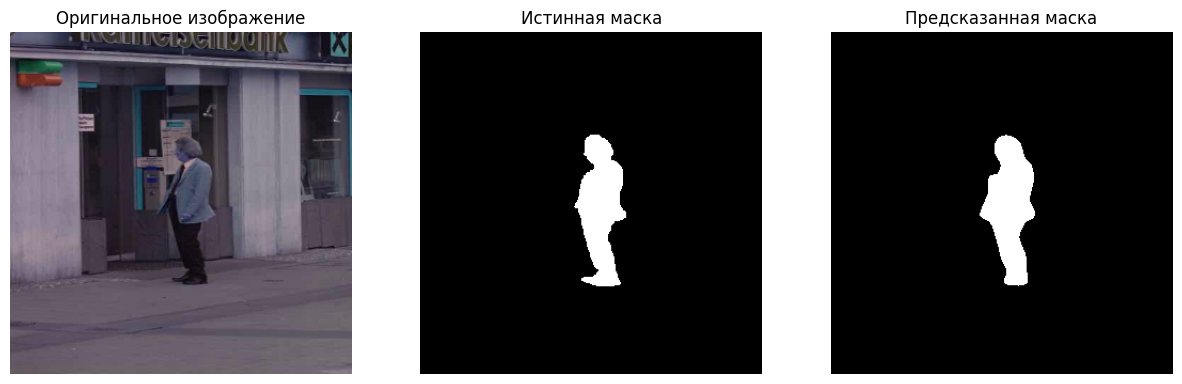

In [111]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

idx = 12

model.load_state_dict(torch.load('/content/best_model.pytorch'))

image, mask = validset[idx]

logits_mask = model(image.to(device).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5).to(torch.float32)

image_np = TF.to_pil_image(image)
mask_np = mask.squeeze().numpy()
pred_mask_np = pred_mask.squeeze().cpu().numpy()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(image_np)
axes[0].set_title("Оригинальное изображение")
axes[0].axis('off')

axes[1].imshow(mask_np, cmap='gray')
axes[1].set_title("Истинная маска")
axes[1].axis('off')

axes[2].imshow(pred_mask_np, cmap='gray')
axes[2].set_title("Предсказанная маска")
axes[2].axis('off')

plt.show()

